# E5.2 - Building ion current models from data 

In this exercise we will explore some of the challenges that come with optimizing a model to data. We'll use a moderately complex model for the ultra-rapidly activating delayed rectifier current ($I_{\rm{Kur}}$). This model is simple in the sense that it has identical rate constants for each activating and deactivating transition, and it is linear. However, you'll see that there are still 12 parameters that can be varied during the fitting process, which can make for challenges in hand tuning the model to a simple activation curve.

We are using a 5-state Markov model published by Zhou et al. 2012:

<img src="fig/Model.svg" width=400>

Where: $$\alpha{} = e^{\frac{V-P1}{P2}}$$
$$\beta{} = \frac{e^{\frac{V-P3}{P4}}\cdot{}e^{\frac{-(V-P5)}{P6}}}{P7+P8\cdot{}e^{\frac{-(V-P9)}{P10}}}$$
$$ K_1 = const_1 $$
$$ K_2 = const_2 $$

Below we will take some time to try to fit this model just to some activation data for this current. In this case we have also allowed the peak conductance ($g_K$) to be a free parameter for your tuning. See how close you can get to the experimental data.

In [4]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import scipy.optimize as opt
import math
from ObFunc import f, Activation

In [5]:
from ipywidgets import interact, FloatSlider
import K_widget as K
import importlib

In [6]:
importlib.reload(K)
K.Markov_Widget()

interactive(children=(FloatSlider(value=45.0, continuous_update=False, description='P1', step=1.0), FloatSlide…

You can probably see that this model is underdetermined and that there are far more parameters than necessary or helpful for fitting this activation curve. What do you think is the reason for this?

### Combinatorial optimisation
Next we will employ a commonly-used algorithm (the Nelder-Mead simplex, or AMOEBA) to optimise the parameter set, and see if it can beat you for accuracy. This algorithm is a form of derivative-free approach to optimise our voltage clamp activation function: 

First let's be specific about the experimental data you will use for fitting. This is a conventional steady-state activation curve for the ultra-rapidly activating delayed rectifier current ($I_{Kur}$), which is largely carried by Kv1.5. The curve is as above:

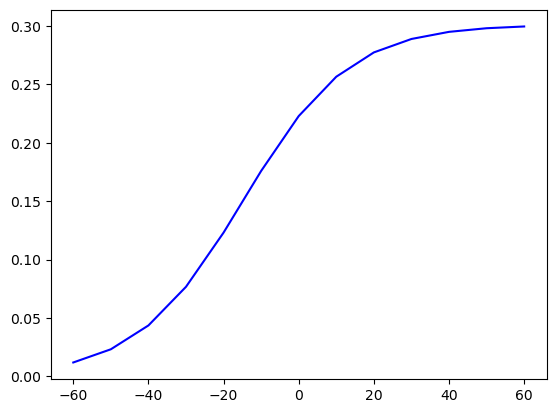

In [12]:
SSA_data = np.loadtxt("SS.txt",dtype='float')

V = SSA_data[:,0] # voltage
I = SSA_data[:,1] # current

plt.figure()
plt.plot(V,I,'b-')

Next we have to define a cost function for comparing the model generated data and the experimental data we have imported. See if you can create this function from the inputs and outputs. First you will need to know the inputs and outputs for the function that simulates channel activation (Activation), for which the summary is shown below. Given a parameter vector (P), Voltage vector (V), and step duration scalar (duration), it returns the simulated time vector (t), open probability vector (Po), and peak $I_{Kur}$ vector (I_peak) as a dictionary:

```
def Activation(P,V,duration):

    'runs activation voltage protocol on the model'
    'P is the vector of parameters [P1... P13]'
    'V is the voltage at each step of the protocol [V1... V15]'
    'duration is a variable specifying the length of each voltage clamp step in time - 1000 ms is conventional'
    
    return out = {'t':t,'Po':Po,'I_peak':model_peaks}
```

In [13]:
def cost(P,V,I,duration):
    
    P = P.tolist() # Opt.fmin returns an array every iteration...
                # but we pass a list to Activation, so we need to typeset.
    
    outs = Activation(P,V,duration)
    model_peaks = outs['I_peak']
       
    dev_vector = model_peaks - I
    error = np.linalg.norm(dev_vector,2) # calculating the error as the L2 norm
    
    return error

Run the optimization and see how it performs:

In [ ]:
step_length = 1000
init_params = [45,20,65,50,20,15,1,0.02,29,15,1e-5,1e-5,0.5] # a starting guess for the parameters

[P_opt, f_opt, iters, funcalls, warnflag] = opt.fmin(cost, init_params, args=(V,I,step_length), maxiter = 300, maxfun = 300, full_output=True, disp=True)


Finally plot your optimized data compared to the experimental data below. Did the algorithm do better than your hand tuning?

In [ ]:
# Your code here:
